In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import os 
import cv2 # For reading the image
import skimage.io 
import matplotlib.pylab    as plt
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline  
# This will display the image inside the notebook


In [2]:
from natsort import natsorted
from sklearn import preprocessing # For whitening
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
rows = 512
cols = 512

In [4]:
# Read the images in Std folder and make npy data
# Read the image directory, construct a tensor and save to npy array
imageDir = './Std/'
images = []
for dirname, subdirList, fileList in os.walk(imageDir):
    # Sort the jpg file numerically
    fileList = natsorted(fileList)
    for f in fileList:
        if f.endswith('png'):
            filename = os.path.join(dirname, f)
            # Print the image file name and read by using opencv
            print f
            print filename
            image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
                
            # Append to the images list
            images.append(image)
# Conver image no numpy array
images = np.array(images)
print images.shape
# Reshape the image to 
images = np.reshape(images, (-1, rows, cols))

# Save the images to numpy array
np.save('std.npy', images)

# Save the image to tif file
skimage.io.imsave('std.tif', images)

barbara.grey.png
./Std/barbara.grey.png
bridge.grey.png
./Std/bridge.grey.png
kiel.grey.png
./Std/kiel.grey.png
lena.grey.png
./Std/lena.grey.png
mandrill.png
./Std/mandrill.png
peppers.png
./Std/peppers.png
(6, 512, 512)


In [5]:
# Specify the tensor layout of signal, filter and sparse map
# S     num ...    1 dimt=1 dimz=1 dimy dimx dimc=3
# D     num ... dimf dimt=1 dimz=1 dimy dimx dimc=3
# X     num ... dimf dimt=1 dimz=1 dimy dimx dimc=3
# dimf is the number of filter is using 
# Note: based on the deep architecture, we always use multi-channel dictionary

# S: Original signal
# D: Dictionary that will be learned
# X: Generated sparse maps

num  = 6
dimf = 64
dimy = 512
dimx = 512

elemSize = [  1,   1, 512, 512]
dataSize = [  6,   1, 512, 512]
dictSize = [  1,  64,  11,  11]
zpadSize = [  1,  64, 512, 512]
blobSize = [  6,  64, 512, 512]

images = np.reshape(images, (num,   1, dimy, dimx))
S = images
D = np.random.normal(size=dictSize)
X = np.random.normal(size=blobSize)

print "S.shape", S.shape
print "D.shape", D.shape
print "X.shape", X.shape


S.shape (6, 1, 512, 512)
D.shape (1, 64, 11, 11)
X.shape (6, 64, 512, 512)


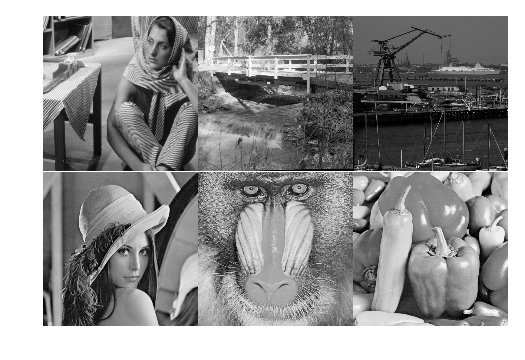

In [6]:
# Plot the samples
for i in range(6):
    plt.subplot(2,3,i+1) # Index of subplot is +1
    plt.axis('off')
    plt.imshow(S[i,0,:,:])
    
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.01)

In [7]:
# Plot over the loop
#%matplotlib inline
#import time
#import pylab as pl
from IPython import display
#for i in range(10):
#    pl.plot(pl.randn(100))
#    display.clear_output(wait=True)
#    display.display(pl.gcf())
#    time.sleep(1.0)

In [8]:
# First we need to normalize the image S by zeromean and std 
avg = np.mean(S, axis=0)
print avg.shape
std = np.std(S, axis=0)
#S_normalized   = (S-avg)/(std+ 1e-6)
#S_processed = S/255.0
S = S.astype(np.float32)
S_processed = S.astype(np.float32)


(1, 512, 512)


In [9]:

ZeroMeanScaler = preprocessing.StandardScaler()
for i in range(6):
    S_processed[i,...] = ZeroMeanScaler.fit_transform(np.squeeze(S_processed[i,...]))
    pass

NormalizeScaler = preprocessing.Normalizer()
for i in range(6):
    S_processed[i,...] = NormalizeScaler.fit_transform(np.squeeze(S_processed[i,...]))
    pass

In [10]:
MinMaxScaler = preprocessing.MinMaxScaler()
for i in range(6):
    #S_processed[i,...] = MinMaxScaler.fit_transform(np.squeeze(S_processed[i,...]))
    pass

In [11]:
#
StandardScaler = preprocessing.StandardScaler()
#print StandardScaler
for i in range(6):
    S_processed[i,...] = StandardScaler.fit_transform(np.squeeze(S[i,...]))
    pass


In [12]:
for i in range(6):
    #print S_processed[i,...].mean(axis=0)
    #print S_processed[i,...].std(axis=0)
    pass

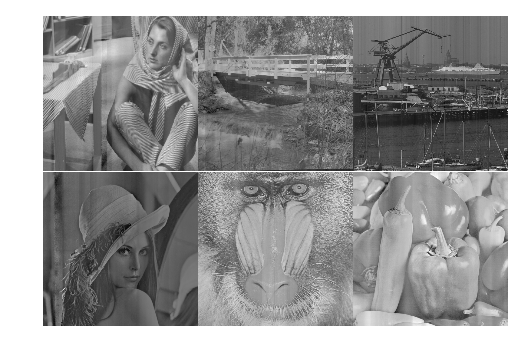

In [13]:

#
#S_processed = S/255.0

for i in range(6):
    plt.subplot(2,3,i+1) # Index of subplot is +1
    plt.axis('off')
    plt.imshow(S_processed[i,0,:,:])
    
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.01)
skimage.io.imsave('normalized.tif', S_processed.astype(np.float32))

In [14]:
print S_processed.shape

(6, 1, 512, 512)


In [15]:
#Initialization
Di = np.complex64(zpadSize) # image domain
Df = np.complex64(zpadSize) # frequency domain

Gi = np.complex64(zpadSize) # image domain
Gf = np.complex64(zpadSize) # frequency domain

Xi = np.complex64(blobSize)
Xf = np.complex64(blobSize)


In [16]:
"""
#     S0,                             # images sk (K images of N pixels each), 
#     D0,                             # initial dictionary d^0_m (M filters), 
#     Lambda=0.1,                     # regularization parameter lambda, 
#     Rho=0.001, Sigma=0.001,         # initial penalty parameters rho_0, sigma_0, 
#     Jd_x=10, mu_x=0.01, tau_x=2,    # penalty auto-update parameters Jx_p, mu_x, tau_x, 
#     Jd_p=10, mu_d=0.01, tau_d=2,    #                                Jd_p, mu_d, tau_d, 
#     alpha_x=1.8, alpha_d=1.8,       # relaxation parameters alpha_x, alpha_d, 
#     Jmax=100,                       # maximum iterations Jmax, 
#     eps_abs=1e-6,                   # absolute and relative stopping tolerances eps_abs, eps_rel
"""

'\n#     S0,                             # images sk (K images of N pixels each), \n#     D0,                             # initial dictionary d^0_m (M filters), \n#     Lambda=0.1,                     # regularization parameter lambda, \n#     Rho=0.001, Sigma=0.001,         # initial penalty parameters rho_\x1a0, sigma_\x1b0, \n#     Jd_x=10, mu_x=0.01, tau_x=2,    # penalty auto-update parameters Jx_p, mu_x, tau_\nx, \n#     Jd_p=10, mu_d=0.01, tau_d=2,    #                                Jd_p, mu_d, tau_\nd, \n#     alpha_x=1.8, alpha_d=1.8,       # relaxation parameters alpha_x, alpha_d, \n#     Jmax=100,                       # maximum iterations Jmax, \n#     eps_abs=1e-6,                   # absolute and relative stopping tolerances eps_abs, eps_rel\n'

 src.shape (6, 1, 64, 64)
shape (6, 1, 128, 128)
<type 'tuple'>
<type 'tuple'>
padding (0, 0, 64, 64)
dst.shape (6, 1, 128, 128)
Sp.shape (6, 1, 128, 128)


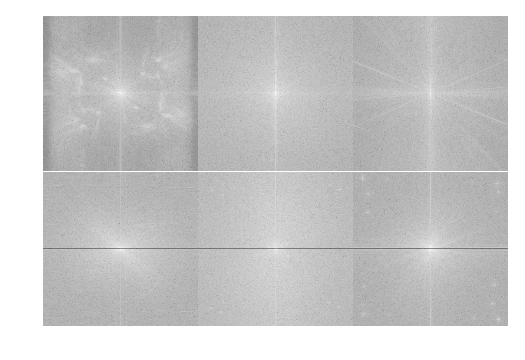

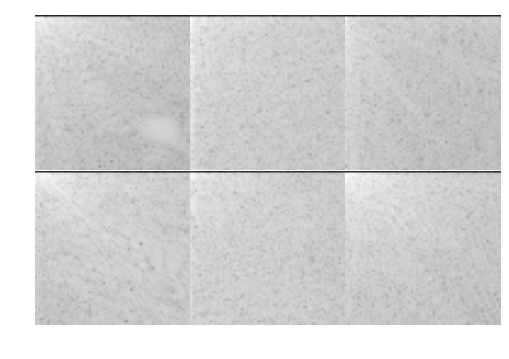

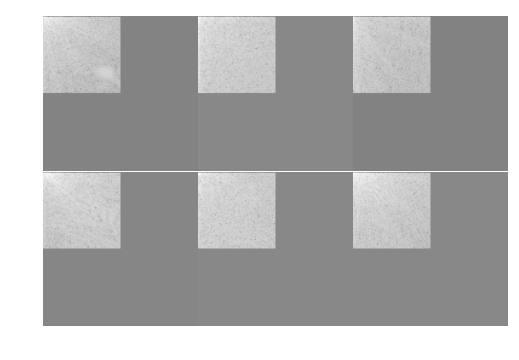

In [44]:
# Run the Convolutional Sparse Coding here  
####################################################################################################################
def bndcrop(src, shape):
    # Crop to the dictionary size
    with tf.Session() as sess:
        dst = src[0:shape[0],0:shape[1],0:shape[2],0:shape[3]]
    return dst

####################################################################################################################
def zeropad(src, shape):
    # Zero padding
    # https://www.tensorflow.org/api_docs/python/array_ops/slicing_and_joining#pad
    print "src.shape", src.shape
    print "shape", shape
    print type(src.shape)
    print type(shape)
    #paddings = tuple(np.subtract(shape - src.shape))
    paddings = tuple(map(lambda x, y: x - y, shape, src.shape))
    print "padding", paddings
    src_ph = tf.placeholder(tf.complex64)
    dst_ph = tf.pad(src, 
                     [[0, paddings[0]],
                      [0, paddings[1]],
                      [0, paddings[2]],
                      [0, paddings[3]]],
                    "CONSTANT")
    with tf.Session() as sess:
        #print "dst.shape", dst.get_shape
        dst = sess.run(dst_ph, feed_dict={src_ph: src})
        
    print "dst.shape", dst.shape
    return dst

####################################################################################################################
def ecsc(
    S0,                             
    D0,
    Lambda=0.1,                     # regularization parameter lambda, 
    Rho=0.001, Sigma=0.001,         # initial penalty parameters rho_0, sigma_0
    Jdx=10, mu_x=0.01, tau_x=2,
    Jd_p=10, mu_d=0.01, tau_d=2,
    alpha_x=1.8, alpha_d=1.8,
    Jmax=100, 
    eps_abs=1e-6,
    eps_rel=1e-6,
):  
################################################################################################################
# Precompute: Sf = fft(Sk) for all k
    Si_ph = tf.placeholder(tf.complex64)
    Sf_ph = tf.fft2d(Si_ph)
    with tf.Session() as sess:
        Sf = sess.run(Sf_ph, feed_dict={Si_ph: S0})
####################################################################################################################
# Initialization
# y^k_m = yprev = u^k^m = 0 for all k, m 
# h_m = 0 for all m
# g_m = gprev = d0 for all m
# Rho = Rho_0
# Sigma = Sigma_0
# j=1
################################################################################################################
    return Sf

####################################################################################################################
# Debug here
# Call the function
Sf = ecsc(S_processed, Di)

# Plot the log
Sf = np.log(np.abs(Sf))
plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1) # Index of subplot is +1
    plt.axis('off')
    plt.imshow(np.fft.fftshift(Sf[i,0,:,:], axes=(0,1)))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.01)



# Debug Cropping
Sc = bndcrop(Sf, (6, 1, 64, 64))
plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1) # Index of subplot is +1
    plt.axis('off')
    plt.imshow((Sc[i,0,:,:]))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.01)

# Debug Padding
Sp = zeropad(Sc, (6, 1, 128, 128))
print "Sp.shape", Sp.shape
plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1) # Index of subplot is +1
    plt.axis('off')
    plt.imshow((Sp[i,0,:,:]))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.01)
